# Homework 11

Fit an autoencoder to the chest xray medical mnist dataset. Do the following
1. Evaluate and compare the training and testing erorr of the autoencoder.
2. Show the result of feeding a few training and testing images through the autoencoder.

You should submit a single ipynb with your results.

You can install the medical mnist data with the command below. Followin is a set of commands to download the data and load it into a pytorch dataset.


In [1]:
!pip install medmnist

     |████████████████████████████████| 87 kB 4.4 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115942 sha256=9ce447174833a3047a6ddf3a0ebcac60a089efeec980061f9e5c345585f3363b
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire


In [8]:
import medmnist
from medmnist import INFO, Evaluator
from tqdm import tqdm
import urllib.request
import PIL
import matplotlib.pyplot as plt
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.utils.data as data

data_flag = 'chestmnist'
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

transform = transforms.ToTensor()

train_dataset = DataClass(split='train', transform=transform, download=True)
test_dataset = DataClass(split='test', transform=transform, download=True)
nonorm_dataset = DataClass(split='train', transform=transforms.ToTensor(), download=True)

Using downloaded and verified file: /root/.medmnist/chestmnist.npz
Using downloaded and verified file: /root/.medmnist/chestmnist.npz
Using downloaded and verified file: /root/.medmnist/chestmnist.npz


In [9]:
## Load it into a train and test loader

train_loader = data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

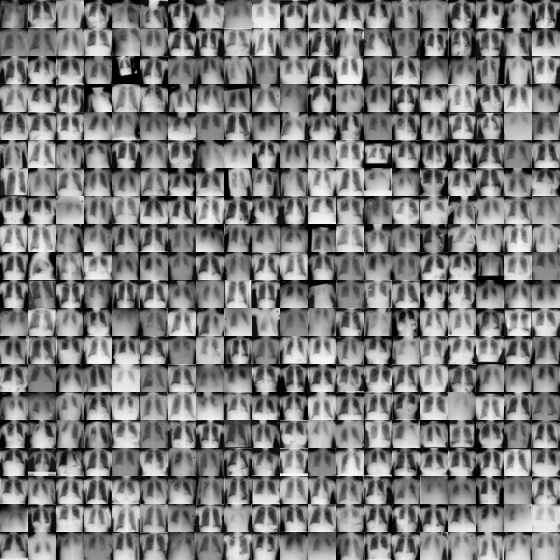

In [10]:
## Visualize the data
train_dataset.montage(length=20)

In [11]:
kernel_size = 5
class autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 6, kernel_size)
        self.conv2 = nn.Conv2d(6, 14, kernel_size)
        self.pool  = nn.MaxPool2d(2, 2)
        self.iconv1 = nn.ConvTranspose2d(14, 6, kernel_size+1, stride = 2)
        self.iconv2 = nn.ConvTranspose2d(6, 1, kernel_size+1, stride = 2)

    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        return x
    
    def decode(self, x):
        x = F.relu(self.iconv1(x))
        ## Use the sigmoid as the final layer 
        ## since we've normalized pixel values to be between 0 and 1
        x = torch.sigmoid(self.iconv2(x))
        return(x)
    
    def forward(self, x):
        return self.decode(self.encode(x))
    
autoencoder = autoencoder()

In [12]:
## Here's some example data by grabbing one batch
tryItOut,label = iter(train_loader).next()
print(tryItOut.shape)

## Let's encode that data
encoded = autoencoder.encode(tryItOut)
print(encoded.shape)

## Now let's decode the encoded data
decoded = autoencoder.decode(encoded)
print(decoded.shape)

## Now let's run the whole thing through
fedForward = autoencoder.forward(tryItOut)
print(fedForward.shape)

torch.Size([100, 1, 28, 28])
torch.Size([100, 14, 4, 4])
torch.Size([100, 1, 28, 28])
torch.Size([100, 1, 28, 28])


In [13]:
#Optimizer
optimizer = torch.optim.Adam(autoencoder.parameters(), lr = 0.001)

#Epochs
n_epochs = 20

autoencoder.train()


for epoch in range(n_epochs):
    for data in train_loader:
        images,label = data
        optimizer.zero_grad()
        outputs = autoencoder.forward(images)
        loss = F.mse_loss(outputs, images)
        loss.backward()
        optimizer.step()
          

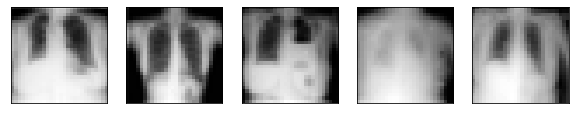

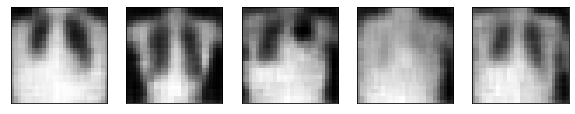

In [14]:
## the data from the last iteration is called images
trainSample = images.detach().numpy()


plt.figure(figsize=(10,5))
for i in range(5): 
  plt.subplot(1, 5,i+1)
  plt.xticks([])
  plt.yticks([])
  img = np.transpose(trainSample[i,:,:,:], (1, 2, 0))
  img = img.reshape(28, 28)
  plt.imshow(img, cmap='gray')


## the output from the last iterations (feed forward through the network) is called outputs
trainOutput = outputs.detach().numpy()

plt.figure(figsize=(10,5))
for i in range(5): 
  plt.subplot(2, 5,i+6)
  plt.xticks([])
  plt.yticks([])
  img = np.transpose(trainOutput[i,:,:,:], (1, 2, 0))
  img = img.reshape(28, 28)
  plt.imshow(img, cmap='gray')


In [16]:
print('Training Error= ',np.sqrt(np.square(np.subtract(trainSample,trainOutput)).mean()))

Training Error=  0.052797697


In [17]:
for data in test_loader:
  images,label = data
  outputs = autoencoder.forward(images)

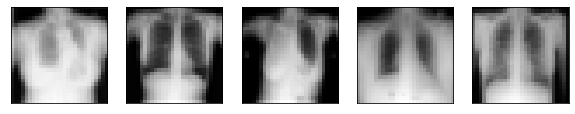

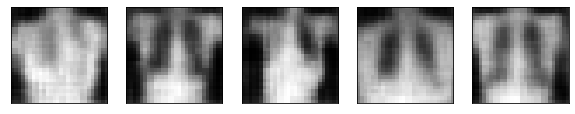

In [18]:
testSample = images.detach().numpy()

plt.figure(figsize=(10,5))
for i in range(5): 
  plt.subplot(1, 5,i+1)
  plt.xticks([])
  plt.yticks([])
  img = np.transpose(testSample[i,:,:,:], (1, 2, 0))
  img = img.reshape(28, 28)
  plt.imshow(img, cmap='gray')


## the output from the last iterations (feed forward through the network) is called outputs
testOutput = outputs.detach().numpy()

plt.figure(figsize=(10,5))
for i in range(5): 
  plt.subplot(2, 5,i+6)
  plt.xticks([])
  plt.yticks([])
  img = np.transpose(testOutput[i,:,:,:], (1, 2, 0))
  img = img.reshape(28, 28)
  plt.imshow(img, cmap='gray')


In [20]:
print('Testing Error= ',np.sqrt(np.square(np.subtract(testSample,testOutput)).mean()))

Testing Error=  0.050886348
